In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from tensorflow import set_random_seed
from keras.callbacks import EarlyStopping

from keras.models import Sequential
# sequential model, for linear stack of NN layers

from keras.layers import Dense, Dropout, Activation, Flatten
# Dense is a standard densely connected NN layer
# Dropout randomly drops a percentage, p, of the neurons from a layer (helps reduce overfitting)

from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# Convolution layers that help efficiently train image data

from keras.utils import np_utils
# used for transforming data

# read training and testing data
X_train = pd.read_pickle("../training_data/X_train.bz2").values
Y_train = pd.read_pickle("../training_data/Y_train.bz2").values
X_test = pd.read_pickle("../training_data/X_test.bz2").values
Y_test = pd.read_pickle("../training_data/Y_test.bz2").values

p = np.shape(X_train)[0] # number of training data
q = np.shape(X_test)[0] # number of test data

m = np.shape(X_train)[1]/2 # number of (T,cv) data
n = np.shape(Y_train)[1] # dimension of output vector

X_train = np.reshape(X_train, (p, 2, m, 1))
X_test = np.reshape(X_test, (q, 2, m, 1))

# check the loaded data
r = np.random.randint(0,p,5)
print r
for i in r:
    plt.figure(0)
    plt.plot(X_train[i][0],X_train[i][1],'+')
    plt.figure(1)
    plt.plot(Y_train[i])

plt.show()

# preprocess input data

# cv lies in the range [0,1], whereas T is in the range [0.1,300]
# we should feature scale T by dividing by 300 (typical maximum value for real data)

X_train[:,0,:,0] /= 300.
X_test[:,0,:,0] /= 300.
# normalize so values range between 0 and 1

# check the processed data
r = np.random.randint(0,p,5)
print r
for i in r:
    plt.figure(0)
    plt.plot(X_train[i][0],X_train[i][1],'+')
    plt.figure(1)
    plt.plot(Y_train[i])

Using TensorFlow backend.


[19050 57589 43912 52054 12176]


<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

[26280 16828  8594 23177 30936]


In [2]:
#-----------------------------------------------------------------------------
# Define custom loss functions for regression in Keras 
#-----------------------------------------------------------------------------
#
# REF: https://github.com/keras-team/keras/issues/7947

from keras import backend

# root mean squared error (rmse) for regression
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# mean squared error (mse) for regression
def mse(y_true, y_pred):
    return backend.mean(backend.square(y_pred - y_true), axis=-1)

# coefficient of determination (R^2) for regression
def r_square(y_true, y_pred):
    SS_res =  backend.sum(backend.square(y_true - y_pred)) 
    SS_tot = backend.sum(backend.square(y_true - backend.mean(y_true))) 
    return (1 - SS_res/(SS_tot + backend.epsilon()))

def r_square_loss(y_true, y_pred):
    SS_res =  backend.sum(backend.square(y_true - y_pred)) 
    SS_tot = backend.sum(backend.square(y_true - backend.mean(y_true))) 
    return 1 - ( 1 - SS_res/(SS_tot + backend.epsilon()))

In [ ]:
# custom loss function
#
# minimizes difference in output dos and in calculated heat capacity
#
# boltzmann constant in meV per Kelvin
kB = 0.08617

# phonon DOS properties (units are meV)
n = 240 # length of output array
wmax = 120 # ouput spectra will cover range [dw, wmax]
dw = wmax/(1.*n) # spectrum bin width

# temperature vector properties (units are Kelvin)
m = 300 # length of temperature array
Tmin = 1 # minimum temp
Tmax = 300 # maximum temp

def makeT(m):
    return np.linspace(Tmin, Tmax, m)

def makeW(n):
    return np.linspace(dw, wmax, n)

def kernelFunction(w, T):
    y = np.outer(1/T/kB, w) # m x n matrix
    return y*y*np.exp(-y)/(np.exp(-y)-1)**2

w = makeW(n)
T = makeT(m)
kernel = backend.variable(np.array([kernelFunction(w,T) for i in range(32)]))

def customLoss(y_true, y_pred):
    cV_true = backend.batch_dot(kernel, y_true)
    cV_pred = backend.batch_dot(kernel, y_pred)
    a = mse(y_true, y_pred)
    b = mse(cV_true, cV_pred)
    cost = a + b
    return cost

In [ ]:
a = backend.placeholder((32,240))
b = backend.placeholder((32,300,240))
c = backend.batch_dot(b,a)
mse(c,c)
mse(a,a)+mse(c,c)
customLoss(a,a)

In [47]:
# set random seeds for repeatable behaviour
np.random.seed(140590)
set_random_seed(140590)

# here we define the model architecture
model = Sequential()

#input layer
model.add(Conv2D(4, (2, 2), input_shape=(2, m, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
print model.output_shape

model.add(Flatten())
print model.output_shape

model.add(Dense(240,activation='relu'))
model.add(Dropout(0.5))
print model.output_shape

model.add(Dense(n, activation='softmax'))
print model.output_shape

(None, 1, 299, 4)
(None, 1196)
(None, 240)
(None, 240)


In [48]:
# here we compile the model and define a loss function
model.compile(loss='mean_squared_error', optimizer='Nadam', metrics=['mean_squared_error', rmse, r_square])

In [49]:
# enabling early stopping based on mean_squared_error
earlystopping = EarlyStopping(monitor='mean_squared_error', patience=10, verbose=1, mode='auto')

In [50]:
# now we can fit the model
result = model.fit(X_train, Y_train, batch_size=32, epochs=240, verbose=1, validation_data=(X_test, Y_test), callbacks=[earlystopping])

Train on 60000 samples, validate on 10000 samples
Epoch 1/240
60000/60000 [==============================] - 27s 443us/step - loss: 2.0327e-05 - mean_squared_error: 2.0327e-05 - rmse: 0.0041 - r_square: 0.6172 - val_loss: 1.3345e-05 - val_mean_squared_error: 1.3345e-05 - val_rmse: 0.0033 - val_r_square: 0.7495
Epoch 2/240
60000/60000 [==============================] - 24s 403us/step - loss: 1.5798e-05 - mean_squared_error: 1.5798e-05 - rmse: 0.0036 - r_square: 0.7026 - val_loss: 1.1737e-05 - val_mean_squared_error: 1.1737e-05 - val_rmse: 0.0032 - val_r_square: 0.7792
Epoch 3/240
60000/60000 [==============================] - 25s 419us/step - loss: 1.4809e-05 - mean_squared_error: 1.4809e-05 - rmse: 0.0035 - r_square: 0.7208 - val_loss: 1.0902e-05 - val_mean_squared_error: 1.0902e-05 - val_rmse: 0.0031 - val_r_square: 0.7947
Epoch 4/240
60000/60000 [==============================] - 28s 470us/step - loss: 1.4395e-05 - mean_squared_error: 1.4395e-05 - rmse: 0.0035 - r_square: 0.7288 - va

Epoch 32/240
60000/60000 [==============================] - 25s 408us/step - loss: 1.1910e-05 - mean_squared_error: 1.1910e-05 - rmse: 0.0032 - r_square: 0.7746 - val_loss: 8.2369e-06 - val_mean_squared_error: 8.2369e-06 - val_rmse: 0.0027 - val_r_square: 0.8438
Epoch 33/240
60000/60000 [==============================] - 24s 395us/step - loss: 1.1921e-05 - mean_squared_error: 1.1921e-05 - rmse: 0.0032 - r_square: 0.7748 - val_loss: 8.3451e-06 - val_mean_squared_error: 8.3451e-06 - val_rmse: 0.0027 - val_r_square: 0.8419
Epoch 34/240
60000/60000 [==============================] - 24s 405us/step - loss: 1.1890e-05 - mean_squared_error: 1.1890e-05 - rmse: 0.0032 - r_square: 0.7756 - val_loss: 8.1677e-06 - val_mean_squared_error: 8.1677e-06 - val_rmse: 0.0027 - val_r_square: 0.8453
Epoch 35/240
60000/60000 [==============================] - 24s 404us/step - loss: 1.1787e-05 - mean_squared_error: 1.1787e-05 - rmse: 0.0032 - r_square: 0.7770 - val_loss: 8.2409e-06 - val_mean_squared_error: 8

60000/60000 [==============================] - 28s 469us/step - loss: 1.1328e-05 - mean_squared_error: 1.1328e-05 - rmse: 0.0031 - r_square: 0.7864 - val_loss: 8.2657e-06 - val_mean_squared_error: 8.2657e-06 - val_rmse: 0.0027 - val_r_square: 0.8443
Epoch 64/240
60000/60000 [==============================] - 28s 467us/step - loss: 1.1403e-05 - mean_squared_error: 1.1403e-05 - rmse: 0.0031 - r_square: 0.7844 - val_loss: 7.6546e-06 - val_mean_squared_error: 7.6546e-06 - val_rmse: 0.0026 - val_r_square: 0.8551
Epoch 65/240
60000/60000 [==============================] - 25s 422us/step - loss: 1.1281e-05 - mean_squared_error: 1.1281e-05 - rmse: 0.0031 - r_square: 0.7867 - val_loss: 7.8346e-06 - val_mean_squared_error: 7.8346e-06 - val_rmse: 0.0026 - val_r_square: 0.8516
Epoch 66/240
60000/60000 [==============================] - 28s 469us/step - loss: 1.1299e-05 - mean_squared_error: 1.1299e-05 - rmse: 0.0031 - r_square: 0.7867 - val_loss: 7.8422e-06 - val_mean_squared_error: 7.8422e-06 - v

60000/60000 [==============================] - 24s 399us/step - loss: 1.1100e-05 - mean_squared_error: 1.1100e-05 - rmse: 0.0031 - r_square: 0.7904 - val_loss: 7.4134e-06 - val_mean_squared_error: 7.4134e-06 - val_rmse: 0.0025 - val_r_square: 0.8595
Epoch 95/240
60000/60000 [==============================] - 24s 401us/step - loss: 1.1134e-05 - mean_squared_error: 1.1134e-05 - rmse: 0.0031 - r_square: 0.7897 - val_loss: 7.7375e-06 - val_mean_squared_error: 7.7375e-06 - val_rmse: 0.0026 - val_r_square: 0.8532
Epoch 96/240
60000/60000 [==============================] - 24s 404us/step - loss: 1.1153e-05 - mean_squared_error: 1.1153e-05 - rmse: 0.0031 - r_square: 0.7896 - val_loss: 7.4291e-06 - val_mean_squared_error: 7.4291e-06 - val_rmse: 0.0026 - val_r_square: 0.8591
Epoch 97/240
60000/60000 [==============================] - 24s 399us/step - loss: 1.1085e-05 - mean_squared_error: 1.1085e-05 - rmse: 0.0031 - r_square: 0.7905 - val_loss: 8.0150e-06 - val_mean_squared_error: 8.0150e-06 - v

60000/60000 [==============================] - 17s 284us/step - loss: 1.1018e-05 - mean_squared_error: 1.1018e-05 - rmse: 0.0030 - r_square: 0.7917 - val_loss: 7.6290e-06 - val_mean_squared_error: 7.6290e-06 - val_rmse: 0.0026 - val_r_square: 0.8558
Epoch 126/240
60000/60000 [==============================] - 18s 296us/step - loss: 1.0886e-05 - mean_squared_error: 1.0886e-05 - rmse: 0.0030 - r_square: 0.7942 - val_loss: 7.3438e-06 - val_mean_squared_error: 7.3438e-06 - val_rmse: 0.0025 - val_r_square: 0.8610
Epoch 127/240
60000/60000 [==============================] - 20s 331us/step - loss: 1.0897e-05 - mean_squared_error: 1.0897e-05 - rmse: 0.0030 - r_square: 0.7936 - val_loss: 7.0334e-06 - val_mean_squared_error: 7.0334e-06 - val_rmse: 0.0025 - val_r_square: 0.8665
Epoch 128/240
60000/60000 [==============================] - 22s 375us/step - loss: 1.0965e-05 - mean_squared_error: 1.0965e-05 - rmse: 0.0030 - r_square: 0.7926 - val_loss: 7.3901e-06 - val_mean_squared_error: 7.3901e-06 

In [51]:
# get predictions
Y_pred = model.predict(X_test)

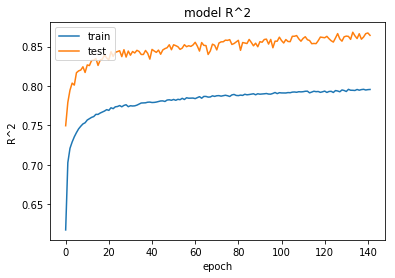

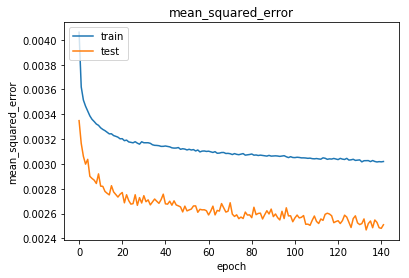

In [52]:
# plot training curve for R^2 (beware of scale, starts very low negative)
plt.plot(result.history['r_square'])
plt.plot(result.history['val_r_square'])
plt.title('model R^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
           
# plot training curve for rmse
plt.plot(result.history['rmse'])
plt.plot(result.history['val_rmse'])
plt.title('mean_squared_error')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [53]:
# print statistical figures of merit

import sklearn.metrics, math
print("\n")
print("Mean absolute error (MAE):      %f" % sklearn.metrics.mean_absolute_error(Y_test,Y_pred))
print("Mean squared error (MSE):       %f" % sklearn.metrics.mean_squared_error(Y_test,Y_pred))
print("Root mean squared error (RMSE): %f" % math.sqrt(sklearn.metrics.mean_squared_error(Y_test,Y_pred)))
print("R square (R^2):                 %f" % sklearn.metrics.r2_score(Y_test,Y_pred))



Mean absolute error (MAE):      0.001216
Mean squared error (MSE):       0.000007
Root mean squared error (RMSE): 0.002675
R square (R^2):                 0.664329


3313


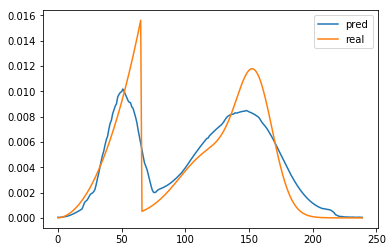

In [57]:
i = np.random.randint(0,q)
print i

plt.plot(Y_pred[i])
plt.plot(Y_test[i])

plt.legend(['pred', 'real'], loc='upper right')
plt.show()

2234


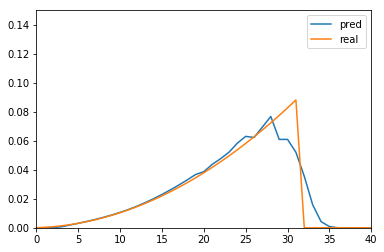

4160


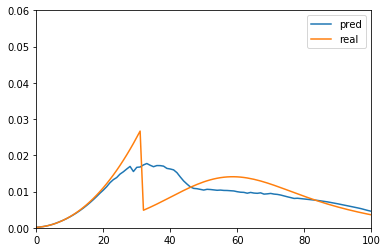

7606


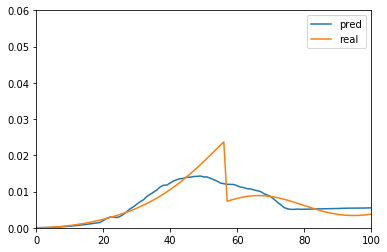

In [58]:
i = 2234
print i

plt.plot(Y_pred[i])
plt.plot(Y_test[i])
plt.legend(['pred', 'real'], loc='upper right')
plt.axis([0,40,0,0.15])
plt.show()

i = 4160
print i

plt.plot(Y_pred[i])
plt.plot(Y_test[i])
plt.legend(['pred', 'real'], loc='upper right')
plt.axis([0,100,0,0.06])
plt.show()

i = 7606
print i

plt.plot(Y_pred[i])
plt.plot(Y_test[i])
plt.legend(['pred', 'real'], loc='upper right')
plt.axis([0,100,0,0.06])
plt.show()

In [ ]:
# save model architecture, weights, training config, and state to HD5 file
model.save('./hc-CNN_005_linear_NAdam_MSE_e064_b32.h5')

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model-CNN-005.png')

In [ ]:
T = np.linspace(1,300,300)
w = makeW(240)
i=50
plt.plot(Y_pred[i])
plt.plot(Y_test[i])
plt.legend(['pred', 'real'], loc='upper right')
plt.show()
plt.plot(T,cv(Y_pred[i],T))
dat = X_test[i].reshape((2,128))
plt.plot(dat[0]*300,dat[1])